# Home Exercise 1 on Machine Translation
Implement a sequence2sequence to translate English to Vietnamese. In this exercise, we will sequentially practice the steps to build a machine learning system for the machine translation task using a seq2seq model. These steps include downloading and preprocessing bilingual data, creating training data, building a seq2seq model with attention, visualizing attention data, and translating new sentences on real-world data.

Data: IWSLT'15 English-Vietnamese (Train set: train.en and train.vi||| Val set: tst2012.en and tst2012.vi ||| Test set: tst2013.en and tst2013.vi).


Note: Submit only a single Jupyter Notebook file that can handle all tasks, including data downloading, preprocessing, model training and model evaluation. (Submissions that do not follow the guidelines will receive a score of 0.)

# This notebook run about 4 hours

# Step 1: install torchtext and library for preprocessing

In [1]:
!pip install torchtext==0.17.1 underthesea numpy==1.26.4
!pip install torch==2.2.1 torchtext==0.17.1 torchvision==0.17.1 transformers==4.47.0 evaluate --force-reinstall --no-deps
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166

In [2]:
import os
import torch
# Configure PyTorch memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Clear cache
torch.cuda.empty_cache()

In [3]:
import pandas as pd
import numpy as np
import re,string
from underthesea import word_tokenize
import torch
import torch.nn as nn
import math
import warnings
import random
import evaluate
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

2025-04-26 15:08:54.986798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745680135.195662      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745680135.250689      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!gdown 1-6rWU8YrKoROCXelZdd1XTytYZNOkxe_ -O archive.zip
!unzip -o archive.zip -d archive

Downloading...
From: https://drive.google.com/uc?id=1-6rWU8YrKoROCXelZdd1XTytYZNOkxe_
To: /kaggle/working/archive.zip
100%|███████████████████████████████████████| 10.8M/10.8M [00:00<00:00, 135MB/s]
Archive:  archive.zip
  inflating: archive/IWSLT'15 en-vi/dict.en-vi.txt  
  inflating: archive/IWSLT'15 en-vi/luong-manning-iwslt15.pdf  
  inflating: archive/IWSLT'15 en-vi/train.en.txt  
  inflating: archive/IWSLT'15 en-vi/train.vi.txt  
  inflating: archive/IWSLT'15 en-vi/tst2012.en.txt  
  inflating: archive/IWSLT'15 en-vi/tst2012.vi.txt  
  inflating: archive/IWSLT'15 en-vi/tst2013.en.txt  
  inflating: archive/IWSLT'15 en-vi/tst2013.vi.txt  
  inflating: archive/IWSLT'15 en-vi/vocab.en.txt  
  inflating: archive/IWSLT'15 en-vi/vocab.vi.txt  


# Step 2: Loading data and preprocessing
# Preprocessing Steps
+ Remove punctuation from both English (en) and Vietnamese (vi) texts.

+ Convert all text to lowercase.

+ Trim leading and trailing whitespaces.

+ Normalize spaces by replacing multiple spaces with a single space.

In [5]:
def load_data(path):
    with open(path,'r',encoding='utf-8') as f:
        data = f.read().strip().splitlines()

    return data

In [6]:

train_english = load_data("archive/IWSLT'15 en-vi/train.en.txt")
train_vietnam = load_data("archive/IWSLT'15 en-vi/train.vi.txt")
validation_english = load_data("archive/IWSLT'15 en-vi/tst2012.en.txt")
validation_vietnam = load_data("archive/IWSLT'15 en-vi/tst2012.vi.txt")
test_english = load_data("archive/IWSLT'15 en-vi/tst2013.en.txt")
test_vietnam = load_data("archive/IWSLT'15 en-vi/tst2013.vi.txt")



# Create a pandas DataFrame and then a Hugging Face Dataset.
train_df = pd.DataFrame({"en": train_english, "vi": train_vietnam})
valid_df = pd.DataFrame({"en": validation_english, "vi": validation_vietnam})
test_df = pd.DataFrame({"en": test_english, "vi": test_vietnam})
print("Number of training examples:", len(train_df), len(valid_df),len(test_df) )

Number of training examples: 133317 1553 1268


In [7]:
def preprocessing(pd): 
  pd["en"] = pd["en"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  pd["vi"] = pd["vi"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))  
  pd["en"] = pd["en"].apply(lambda ele: ele.lower()) # convert text to lowercase
  pd["vi"] = pd["vi"].apply(lambda ele: ele.lower())
  pd["en"] = pd["en"].apply(lambda ele: ele.strip()) 
  pd["vi"] = pd["vi"].apply(lambda ele: ele.strip()) 
  pd["en"] = pd["en"].apply(lambda ele: re.sub("\s+", " ", ele)) 
  pd["vi"] = pd["vi"].apply(lambda ele: re.sub("\s+", " ", ele))
    
  return pd

train_df = preprocessing(train_df)
valid_df = preprocessing(valid_df)
test_df = preprocessing(test_df)

In [8]:
from datasets import Dataset
train_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(valid_df)
test_data = Dataset.from_pandas(test_df)
train_data[0]

{'en': 'rachel pike the science behind a climate headline',
 'vi': 'khoa học đằng sau một tiêu đề về khí hậu'}

In [9]:
en_tokenizer = get_tokenizer('basic_english')
def vi_tokenizer(sentence):
    tokens = word_tokenize(sentence)
    return tokens
vi_tokenizer = get_tokenizer(vi_tokenizer)
print(en_tokenizer(train_data[0]["en"]))
print(vi_tokenizer(train_data[0]["vi"]))

['rachel', 'pike', 'the', 'science', 'behind', 'a', 'climate', 'headline']
['khoa học', 'đằng', 'sau', 'một', 'tiêu đề', 'về', 'khí hậu']


In [10]:
def tokenize_example(example, en_tokenizer, vi_tokenizer, max_length, sos_token, eos_token):
    en_tokens = en_tokenizer(example["en"][:max_length])
    vi_tokens = vi_tokenizer(example["vi"][:max_length])
    en_tokens = [sos_token] + en_tokens + [eos_token]
    vi_tokens = [sos_token] + vi_tokens + [eos_token]
    return {"en_tokens":en_tokens, "vi_tokens":vi_tokens}

In [11]:
sos_token = "<sos>"
eos_token = "<eos>"
max_length = 1000
fn_kwargs = {"en_tokenizer" : en_tokenizer, 
             "vi_tokenizer": vi_tokenizer, 
             "max_length":max_length, "sos_token" : sos_token, "eos_token": eos_token}
train_data = train_data.map(tokenize_example, fn_kwargs = fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs = fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs = fn_kwargs)

Map:   0%|          | 0/133317 [00:00<?, ? examples/s]

Map:   0%|          | 0/1553 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

In [12]:
min_freq = 3
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

vi_vocab = build_vocab_from_iterator(
    train_data["vi_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)
print(f"English vocab size: {len(en_vocab)}")
print(f"Vietnamese vocab size: {len(vi_vocab)}")

English vocab size: 22368
Vietnamese vocab size: 16127


In [13]:
unk_index = en_vocab["<unk>"]
pad_index = en_vocab["<pad>"]
en_vocab.set_default_index(unk_index)
vi_vocab.set_default_index(pad_index)

In [14]:
def numericalize_example(example, en_vocab, vi_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    vi_ids = vi_vocab.lookup_indices(example["vi_tokens"])
    return {"en_ids":en_ids, "vi_ids":vi_ids}

In [15]:
train_data = train_data.map(numericalize_example, fn_kwargs = {"en_vocab": en_vocab, "vi_vocab": vi_vocab})
test_data = test_data.map(numericalize_example, fn_kwargs = {"en_vocab": en_vocab, "vi_vocab": vi_vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs = {"en_vocab": en_vocab, "vi_vocab": vi_vocab})

Map:   0%|          | 0/133317 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1553 [00:00<?, ? examples/s]

In [16]:
train_data = train_data.with_format(type = "torch", columns = ["en_ids", "vi_ids"])
valid_data = valid_data.with_format(type = "torch", columns = ["en_ids", "vi_ids"])
test_data = test_data.with_format(type = "torch", columns = ["en_ids", "vi_ids"])

In [17]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["vi_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "vi_ids": batch_de_ids,
        }
        return batch

    return collate_fn

In [18]:
from torch.utils.data import DataLoader
batch_size = 32

train_data_loader = DataLoader(train_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)
valid_data_loader = DataLoader(valid_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)
test_data_loader = DataLoader(test_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)

# Step 3: Building the Seq2Seq model with attention

+ **Encoder**: Embeds input, processes with bidirectional GRU, projects combined hidden states for the decoder.

+ **Attention**: Computes attention scores between decoder hidden state and encoder outputs.

+ **Decoder**: Embeds input, applies attention, processes through GRU, and generates output tokens.

+ **Seq2Seq**: Encodes source sequence, decodes target sequence step-by-step with optional teacher forcing.

In [19]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )

        return outputs, hidden

In [20]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

In [21]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_length):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [23]:
input_dim = len(en_vocab)
output_dim = len(vi_vocab)
encoder_embedding_dim = 128
decoder_embedding_dim = 128
encoder_hidden_dim = 256
decoder_hidden_dim = 256
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [24]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(22368, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(16127, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=16127, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 21,004,287 trainable parameters


In [26]:

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [27]:
import tqdm
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for batch in tqdm.tqdm(data_loader, desc = "training..."):
        src = batch["en_ids"].to(device)
        trg = batch["vi_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [28]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc = "evaluating..."):
            src = batch["en_ids"].to(device)
            trg = batch["vi_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [29]:

n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in range(n_epochs):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

evaluating...: 100%|██████████| 49/49 [00:05<00:00,  8.68it/s]


	Train Loss:   5.421 | Train PPL: 226.065
	Valid Loss:   5.055 | Valid PPL: 156.761


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  8.86it/s]


	Train Loss:   4.379 | Train PPL:  79.725
	Valid Loss:   4.813 | Valid PPL: 123.051


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  8.88it/s]


	Train Loss:   3.991 | Train PPL:  54.117
	Valid Loss:   4.693 | Valid PPL: 109.142


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  8.69it/s]


	Train Loss:   3.758 | Train PPL:  42.850
	Valid Loss:   4.694 | Valid PPL: 109.246


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  9.02it/s]


	Train Loss:   3.616 | Train PPL:  37.179
	Valid Loss:   4.722 | Valid PPL: 112.362


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  9.19it/s]


	Train Loss:   3.512 | Train PPL:  33.526
	Valid Loss:   4.688 | Valid PPL: 108.581


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  9.40it/s]


	Train Loss:   3.431 | Train PPL:  30.917
	Valid Loss:   4.692 | Valid PPL: 109.037


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  8.58it/s]


	Train Loss:   3.369 | Train PPL:  29.057
	Valid Loss:   4.735 | Valid PPL: 113.908


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  9.06it/s]


	Train Loss:   3.315 | Train PPL:  27.524
	Valid Loss:   4.713 | Valid PPL: 111.333


evaluating...: 100%|██████████| 49/49 [00:05<00:00,  9.04it/s]

	Train Loss:   3.271 | Train PPL:  26.327
	Valid Loss:   4.765 | Valid PPL: 117.309


In [30]:

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

evaluating...: 100%|██████████| 40/40 [00:05<00:00,  7.11it/s]

| Test Loss: 4.770 | Test PPL: 117.911 |


In [31]:
def translate_sentence(
    sentence,
    model,
    en_tokenizer,
    vi_tokenizer,
    en_vocab,
    vi_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            en_tokens = [token for token in en_tokenizer(sentence)]
        else:
            en_tokens = [token for token in sentence]
        if lower:
            en_tokens = [token.lower() for token in en_tokens]
        en_tokens = [sos_token] + en_tokens + [eos_token]
        ids = en_vocab.lookup_indices(en_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == vi_vocab[eos_token]:
                break
        vi_tokens = vi_vocab.lookup_tokens(inputs)
    return vi_tokens, en_tokens, attentions[: len(vi_tokens) - 1]

# Step 4: Visualize a attention data

/tmp/ipykernel_19/2059783091.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, rotation=90)
/tmp/ipykernel_19/2059783091.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


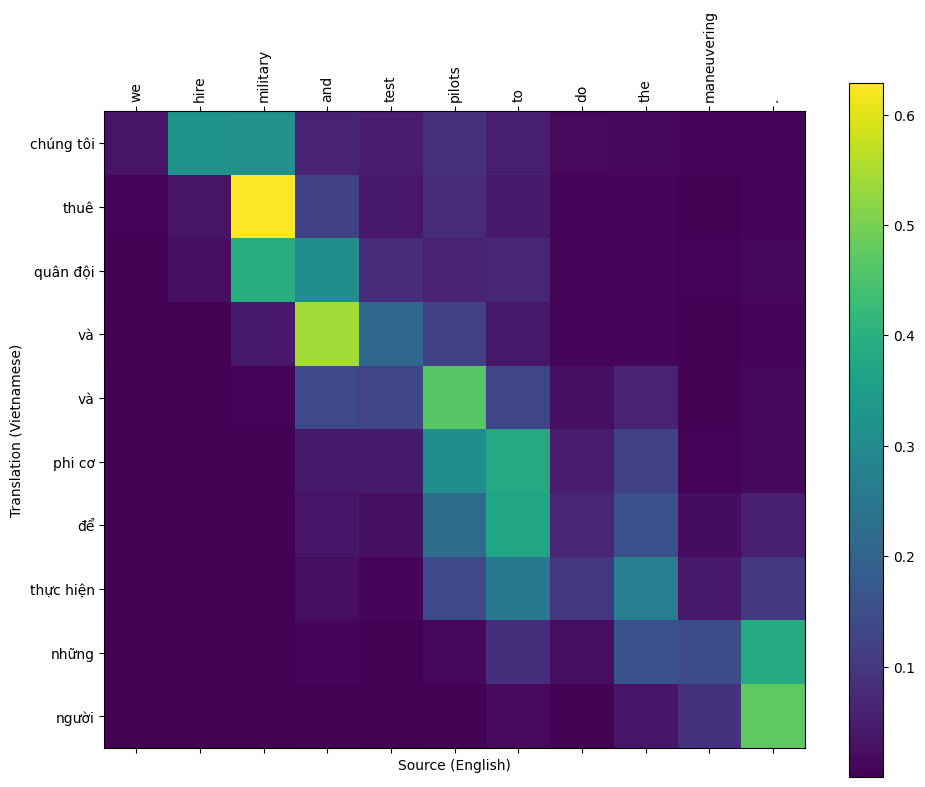

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def display_attention(sentence, translation, attention):
    """
    Visualizes attention weights as a heatmap.
    
    Args:
        sentence: List of source tokens
        translation: List of target tokens
        attention: Attention weights from the model
    """
    # Remove start and end tokens for better visualization
    sentence = sentence[1:-1]
    translation = translation[1:-1]
    
    # Create figure and axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Plot heatmap
    #attention = attention.cpu().numpy()[:len(translation), :len(sentence)]
    #cax = ax.matshow(attention, cmap='viridis')
    attention = attention.squeeze(1).cpu().numpy()[:len(translation), :len(sentence)]
    cax = ax.matshow(attention, cmap='viridis')
    
    # Set tick labels
    ax.set_xticklabels([''] + sentence, rotation=90)
    ax.set_yticklabels([''] + translation)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    # Add colorbar and labels
    plt.colorbar(cax)
    plt.xlabel('Source (English)')
    plt.ylabel('Translation (Vietnamese)')
    plt.tight_layout()
    plt.show()

# Example usage with a specific sentence
sentence = "We hire military and test pilots to do the maneuvering."
lower = True
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_tokenizer,
    vi_tokenizer,
    en_vocab,
    vi_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

# Visualize the attention weights
display_attention(sentence_tokens, translation, attention)

# Step 5: Translate a sentence

In [33]:
sentence = "We hire military and test pilots to do the maneuvering ."
lower = True
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_tokenizer,
    vi_tokenizer,
    en_vocab,
    vi_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [34]:
translation

['<sos>',
 'chúng tôi',
 'thuê',
 'quân đội',
 'và',
 'và',
 'phi cơ',
 'để',
 'thực hiện',
 'những',
 'người',
 '<eos>']

In [35]:
test_data = test_data.with_format(type=None)

In [36]:
translations = [
    translate_sentence(
        example["en"],
        model,
        en_tokenizer,
        vi_tokenizer,
        en_vocab,
        vi_vocab,
        lower,
        sos_token,
        eos_token,
        device
    )[0] for example in tqdm.tqdm(test_data)
]

100%|██████████| 1268/1268 [00:19<00:00, 64.34it/s]


In [37]:
sacrebleu = evaluate.load("sacrebleu")

In [38]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["vi"]] for example in test_data]

In [39]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token for token in nlp(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [40]:
tokenizer_fn = get_tokenizer_fn(vi_tokenizer, lower)

In [41]:
results = sacrebleu.compute(
    predictions=predictions, references=references
)

In [42]:
results

{'score': 14.314012806800653,
 'counts': [13018, 6159, 2817, 1310],
 'totals': [25542, 24274, 23006, 21739],
 'precisions': [50.96703468796492,
  25.372826892971904,
  12.244631835173433,
  6.026036156216938],
 'bp': 0.8144275934832743,
 'sys_len': 25542,
 'ref_len': 30785}

# BLEU Score Analysis
BLEU Score: 14.31 — This is low, suggesting the model's generated outputs are quite different from the reference translations.

Precision:

+ 1-gram: ~51% (good basic word match)

+ 2-gram: ~25%

+ 3-gram: ~12%

+ 4-gram: ~6% (very low for phrase-level fluency)

Brevity Penalty (BP): 0.81 — Indicates the model outputs are too short compared to references.

System vs Reference Length:

System length: 25,542

Reference length: 30,785

# Issues
Poor longer n-gram matches (fluency, phrase structure is weak).

Outputs are shorter than expected (under-generation).

# Suggested Improvements
Train longer or fine-tune the model for more epochs.

Use better tokenization and improve vocabulary coverage.

Apply length penalty during decoding to encourage longer outputs.

Use a more powerful attention mechanism (e.g., multi-head attention).

Increase model size (larger hidden dimensions or more layers).